In [7]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpy import mean,std
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,train_test_split,KFold,GridSearchCV
from sklearn.preprocessing import MinMaxScaler,OrdinalEncoder,LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression,LinearRegression,Perceptron
from sklearn.metrics import accuracy_score,mean_absolute_error,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import VarianceThreshold,SelectKBest,chi2,mutual_info_classif,f_classif,RFE,RFECV,SelectFromModel
from sklearn.neighbors import KNeighborsClassifier,LocalOutlierFactor

#### Dataset description

|variable   | description  | 
|---|---|
|limit_bal | Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit|
| sex | Gender (1 = male; 2 = female)|
| education | Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)|
| marriage | Marital status (1 = married; 2 = single; 3 = others)|
|age| Age (year)|
|pay_0 - pay_6 | History of past monthly payment records (from April to September, 2005): pay_0 = the repayment status in September, 2005; pay_1 = the repayment status in August, 2005; . . .;pay_6 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay on time; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.|
|bill_amt1 - bill_amt6 | Amount of bill statement (New Taiwan dollar). bill_amt1 = amount of bill statement in September, 2005; bill_amt2 = amount of bill statement in August, 2005; . . .; bill_amt6 = amount of bill statement in April, 2005. |
|pay_amt1 - pay_amt6 | Amount of previous payment (New Taiwan dollar). pay_amt1 = amount paid in September, 2005; pay_amt2 = amount paid in August, 2005; . . .;pay_amt6 = amount paid in April, 2005. |
| defaulted | whether or not client defaulted: 1 = yes; 0 = no |

#### Data Cleaning

In [2]:
file = "~/Documents/Github/Springboard/capstone/1/default_of_credit_card_clients.xls"
data = pd.read_excel(file,skiprows=1)
data.columns = data.columns.str.lower() #change columns to lower
data = data.drop('id',axis=1) #drop useless customer id column
data.rename(columns={'default payment next month':'defaulted'},inplace=True) #rename defaulted col

In [3]:
#drop duplicate rows
print(data.shape)
data.drop_duplicates(inplace=True)
print(data.shape)

(30000, 24)
(29965, 24)


In [4]:
#data.iloc[:,:4].describe()
data.describe()

,limit_bal,sex,education,marriage,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,defaulted
count,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000,...,29965.000000,29965.000000,29965.000000,29965.000000,2.996500e+04,29965.000000,29965.000000,29965.000000,29965.000000,29965.000000
mean,167442.005006,1.603738,1.853629,1.551877,35.487969,-0.016753,-0.131854,-0.164392,-0.218922,-0.264509,...,43313.329885,40358.334390,38917.012281,5670.099316,5.927983e+03,5231.688837,4831.617454,4804.897047,5221.498014,0.221258
std,129760.135222,0.489128,0.790411,0.521997,9.219459,1.123492,1.196322,1.195878,1.168175,1.132220,...,64353.514373,60817.130623,59574.147742,16571.849467,2.305346e+04,17616.361124,15674.464538,15286.372298,17786.976864,0.415101
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2360.000000,1787.000000,1262.000000,1000.000000,8.500000e+02,390.000000,300.000000,261.000000,131.000000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19081.000000,18130.000000,17124.000000,2102.000000,2.010000e+03,1804.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54601.000000,50247.000000,49252.000000,5008.000000,5.000000e+03,4512.000000,4016.000000,4042.000000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


We clearly see from summary statistics there exists negative values for bill amounts that do not appear correct (i.e. min of -170000 for **bill_amt4**). We could check if these are possibly user error or due to payment amount. A previous study on this study mentioned this can be treated as a credit where the client overpaid a previous statement. 

In [5]:
negative_billamt = data[(data.bill_amt1 < 0) | (data.bill_amt2 < 0) | (data.bill_amt3 < 0) | (data.bill_amt4 < 0) | (data.bill_amt5 < 0) | (data.bill_amt6 < 0)]
print("Total records:",len(negative_billamt),"Percent:",len(negative_billamt)/len(data))
print("% of defaulted clients:",len(negative_billamt[negative_billamt.defaulted == 1])/len(data[data.defaulted == 1]))

Total records: 1930 Percent: 0.06440847655598197
% of defaulted clients: 0.04796380090497738


Since we do not have enough information to interpret the negative values and the total number of records is minimal, we can discard these row data as they will not add any value to our analysis.

Two other variables, marriage and education, also appear to have recorded values that do not correspond to accepted values in description:

In [6]:
#data[(data.marriage == 0) | (data.marriage == 3)]
# Discard rows where marriage is not 1 or 2
data = data[~data.marriage.isin([0,3])]

In [7]:
# Discard rows where education is not 1, 2, or 3
#data[~data.education.isin([1,2,3])].defaulted.value_counts() #0: 427 1: 33
data = data[data.education.isin([1,2,3])]

In [8]:
print(data.shape)

(29128, 24)


#### Drop columns that contain very small variance

In [9]:
# set feature and target variables
data_test = data.values
X = data_test[:,:-1]
y = data_test[:,-1]
print(X.shape,y.shape)

(29128, 23) (29128,)


>Threshold=0.00, Features=23
>Threshold=0.05, Features=23
>Threshold=0.10, Features=23
>Threshold=0.15, Features=23
>Threshold=0.20, Features=23
>Threshold=0.25, Features=21
>Threshold=0.30, Features=21
>Threshold=0.35, Features=21
>Threshold=0.40, Features=21
>Threshold=0.45, Features=21
>Threshold=0.50, Features=20


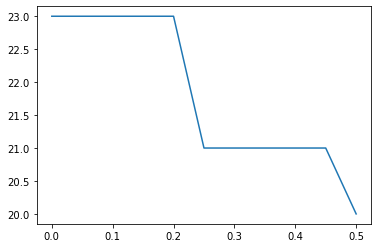

In [10]:
# Using VarianceThreshold method

# define thresholds
thresholds = np.arange(0,0.55,0.05)
# apply transform with each threshold
results = list()
for t in thresholds:
    # define the transform
    transform = VarianceThreshold(threshold=t)
    # transform the input data
    X_sel = transform.fit_transform(X)
    # determine the number of input features
    n_features = X_sel.shape[1]
    print('>Threshold=%.2f, Features=%d' % (t, n_features))
    # store the result
    results.append(n_features)

# plot the threshold vs the number of selected features
plt.plot(thresholds, results)
plt.show()

We see that at a threshold of 0.25 using VarianceThreshold, 2 of the features are eliminated. The threshold is much too large to consider dropping any of the variables. We keep all features for now.

#### Remove outliers

In [41]:
# identify outliers in the training set using local outlier factor 

#LOF generalizes to classification problems when there is significant imbalance in class sizes. Instead of considering it a problem of two classes, consider it a one class problem where the majority class is the main cluster and the minority class is a set of outliers. To do this, the focus of LOF must be shifted from outlier detection to novelty detection.

# As we are not removing any features, we can consider Manhattan distance as the metric for identifying outliers. Manhattan Distance is preferred over the Euclidean distance metric as the dimension of the data increases. 

lof = LocalOutlierFactor(metric = "manhattan",n_neighbors=10, contamination=0.02)
#train set
yhat = lof.fit_predict(X)
# select all rows that are not outliers
mask = yhat != -1
X_pre, y_pre = X[mask, :], y[mask]
# summarize the shape of the updated training
print(X_pre.shape, y_pre.shape)

(28545, 23) (28545,)


In [61]:
print(X.shape, y.shape)

(29128, 23) (29128,)


LOF discarded 417 row data based on the thresholds set

In [220]:
list(data.columns)

['limit_bal',
 'sex',
 'education',
 'marriage',
 'age',
 'pay_0',
 'pay_2',
 'pay_3',
 'pay_4',
 'pay_5',
 'pay_6',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6',
 'defaulted']

#### Handle Missing Values

Given that the data does not contain any missing data based on the summary statistics, we can move forward with feature selection. Reducing the number of features may improve the performance of the chosen model.

In [174]:
#Save cleaned dataset
#dat = pd.DataFrame(y_pre,X_pre,columns=list(data.columns)) #, columns=columns
dat = pd.DataFrame(np.column_stack((X_pre,y_pre)))
dat.columns = list(data.columns)

#print(X.shape,y.shape)
#print(X_pre.shape,y_pre.shape)
dat.to_csv("~/Documents/Github/Springboard/capstone/1/default_of_credit_card_clients_CLEANED.csv",index=False)

In [3]:
#Load dataset after cleaned data save 
dat = pd.read_csv("~/Documents/Github/Springboard/capstone/1/default_of_credit_card_clients_CLEANED.csv")
cols = dat.columns
dat = dat.values
X, y = dat[:,:-1], dat[:,-1]

#### Feature Selection

Our dataset has both numerical and categorical variables. However since the categorical variables have already been encoded to numerical type, we can skip the variable encoding step and move forward with feature selection which we can consider multiple approaches.

In [7]:
# split into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X_pre, y_pre, test_size=0.33, random_state=1) #using X_pre and Y_pre which is the dataset after accounting for outliers
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1) #using X_pre and Y_pre which is the dataset after accounting for outliers
# summarize the shape of the train and test sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(19125, 23) (9420, 23) (19125,) (9420,)


In [8]:
#Using ANOVA F-test Feature Selection - features that are independent of the target variable can be removed from the dataset

# Feature selection should be performed after splitting as there can be information leakage if done before, from the Test-Set.

def select_features(X_train, y_train, X_test, score_func):
    # configure to select all features
    fs = SelectKBest(score_func=score_func, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs


Feature 0: 514.263317
Feature 1: 41.736325
Feature 2: 56.109786
Feature 3: 25.705526
Feature 4: 5.871207
Feature 5: 2377.805052
Feature 6: 1595.146515
Feature 7: 1214.027046
Feature 8: 1003.300824
Feature 9: 931.077347
Feature 10: 776.753679
Feature 11: 5.879665
Feature 12: 2.179871
Feature 13: 3.286308
Feature 14: 1.502294
Feature 15: 0.459277
Feature 16: 0.142817
Feature 17: 109.616605
Feature 18: 67.393332
Feature 19: 69.175679
Feature 20: 59.046772
Feature 21: 47.492184
Feature 22: 66.278421


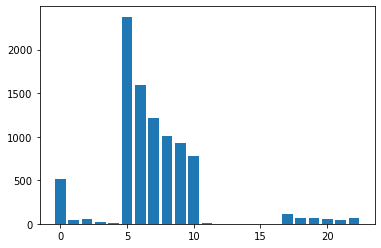

In [9]:
# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test,f_classif)

# what are scores for each of the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))

# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

We can see that some features stand out as perhaps being more relevant than others, with much larger test statistic values. We can consider selecting features 5 to 10 (total of 6) as important features and discarding the others based on this test.

We can try other feature selection method such as mutual classification. We can evaluate models using different feature selection methods (and numbers of features) and select the method that results in a
model with the best performance (best selection of features).

In [10]:
#Evaluating model using all features

# fit the model - use a LR model and predict against test set for comparison
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)
# evaluate the model
yhat = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('All Features - Accuracy: %.2f' % (accuracy*100))

# feature selection
def select_features(X_train, y_train, X_test, score_func, k_features):
    # configure to select a subset of features
    fs = SelectKBest(score_func=score_func, k=k_features)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs


# model built using ANOVA features

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, f_classif, 4)
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('ANOVA feature selection - Accuracy: %.2f' % (accuracy*100))

# model built using Mutual Information features

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, mutual_info_classif, 4)
# fit the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Mutual Information feature selection - Accuracy: %.2f' % (accuracy*100))


All Features - Accuracy: 77.62
ANOVA feature selection - Accuracy: 80.59
Mutual Information feature selection - Accuracy: 80.59


We see that we achieve about the same result for ANOVA and Mutual information feature selection however both an improvement over default selection of all features.

We selected a default of 4 features as observed from the initial results of the f-statistic scores for each feature in the ANOVA test. We can test a range of features to see if other number of features may be better.

#### Feature Selection Tuning

>1 0.821 (0.007)
>2 0.810 (0.006)
>3 0.809 (0.006)
>4 0.809 (0.006)
>5 0.809 (0.006)
>6 0.809 (0.006)
>7 0.777 (0.000)
>8 0.777 (0.000)
>9 0.777 (0.000)
>10 0.777 (0.000)
>11 0.777 (0.000)
>12 0.777 (0.000)
>13 0.777 (0.000)
>14 0.777 (0.000)
>15 0.777 (0.000)
>16 0.777 (0.000)
>17 0.777 (0.001)
>18 0.777 (0.000)
>19 0.777 (0.000)
>20 0.777 (0.000)
>21 0.777 (0.000)
>22 0.777 (0.000)
>23 0.777 (0.000)


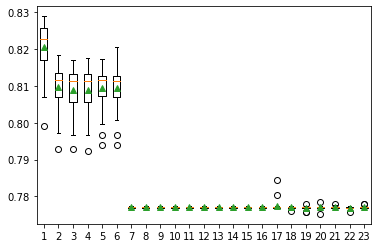

In [11]:
#Use grid search to test a range of different numbers of selected features 

# define the evaluation method
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# define the number of features to evaluate
num_features = [i+1 for i in range(X.shape[1])]
# enumerate each of the features
results = list()

for k in num_features:
    # create pipeline
    model = LogisticRegression(solver='liblinear')
    fs = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline(steps=[('anova',fs), ('lr', model)])
    # evaluate the model
    scores = evaluate_model(pipeline, X_train, y_train)
    results.append(scores)
    # summarize the results
    print('>%d %.3f (%.3f)' % (k, mean(scores), std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=num_features, showmeans=True)
plt.show()

We find that interestingly, selecting one feature returns the highest accuracy from the three repeats of 10-fold cross validation and a drop off after more than 6 features. As seen in the ANOVA feature selection previously, we also get about 6 features that have a high F-score.

We can also consider RFE for feature selection which is a wrapper method, evaluate a range between to 2 to 10 features using decision tree classifier as model to evaluate, then determine which is best number.

In [12]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 10):
    #for i in range(X.shape[1]):
        rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=i)
        model = DecisionTreeClassifier()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

>2 0.675 (0.010)
>3 0.675 (0.008)
>4 0.726 (0.011)
>5 0.727 (0.008)
>6 0.726 (0.010)
>7 0.725 (0.010)
>8 0.725 (0.009)
>9 0.726 (0.010)


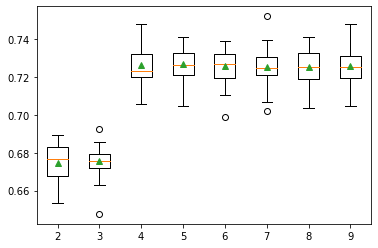

In [13]:
# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

It appears 5 features (>5 0.729 (0.006)) were selected as having highest accuracy. We can check which features were selected using RFE:

(Rerun few times consistently shows 5 features as having the highest accuracy before dropping off after 6 features)

In [14]:
# define RFE
rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
# fit RFE
rfe.fit(X_train, y_train)
# summarize all features
for i in range(X.shape[1]):
    print('Column: %d, Selected=%s, Rank: %d' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected=False, Rank: 5
Column: 1, Selected=False, Rank: 16
Column: 2, Selected=False, Rank: 13
Column: 3, Selected=False, Rank: 17
Column: 4, Selected=False, Rank: 2
Column: 5, Selected=True, Rank: 1
Column: 6, Selected=False, Rank: 12
Column: 7, Selected=False, Rank: 15
Column: 8, Selected=False, Rank: 18
Column: 9, Selected=False, Rank: 14
Column: 10, Selected=False, Rank: 19
Column: 11, Selected=True, Rank: 1
Column: 12, Selected=True, Rank: 1
Column: 13, Selected=False, Rank: 11
Column: 14, Selected=False, Rank: 7
Column: 15, Selected=False, Rank: 10
Column: 16, Selected=True, Rank: 1
Column: 17, Selected=False, Rank: 9
Column: 18, Selected=True, Rank: 1
Column: 19, Selected=False, Rank: 8
Column: 20, Selected=False, Rank: 3
Column: 21, Selected=False, Rank: 6
Column: 22, Selected=False, Rank: 4


We see that columns [5,11,12,16,18] were selected which correspond to the following columns:

In [18]:
cols[[5,11,12,16,18]]

Index(['pay_0', 'bill_amt1', 'bill_amt2', 'bill_amt6', 'pay_amt2'], dtype='object')

We used Decision Tree as the feature selection algorithm within the RFE wrapper. Finally, we can compare and consider other feature selection algorithms to use with RFE to see if there is an improvement using a different feature selection algorithm. We keep 5 as the number of features to select:

>lr 0.793 (0.054)
>per 0.686 (0.010)
>cart 0.727 (0.009)
>rf 0.729 (0.009)
>gbm 0.736 (0.009)


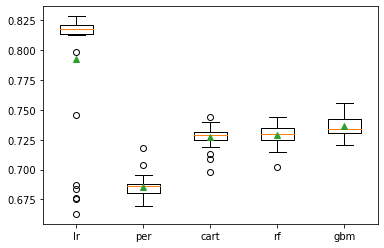

In [111]:
def get_models():
    models = dict()
    # lr
    rfe = RFE(estimator=LogisticRegression(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['lr'] = Pipeline(steps=[('s',rfe),('m',model)])
    # perceptron
    rfe = RFE(estimator=Perceptron(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['per'] = Pipeline(steps=[('s',rfe),('m',model)])
    # cart
    rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['cart'] = Pipeline(steps=[('s',rfe),('m',model)])
    # rf
    rfe = RFE(estimator=RandomForestClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['rf'] = Pipeline(steps=[('s',rfe),('m',model)])
    # gbm
    rfe = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=5)
    model = DecisionTreeClassifier()
    models['gbm'] = Pipeline(steps=[('s',rfe),('m',model)])
    return models

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_train, y_train)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

It looks like using Logistic Regression wrapped in RFE for feature selection has a higher accuracy than using Decision tree classifier. We can check if LR produces a different set of ranked features than Decision Tree classifier (CART).

In [124]:
# define RFE
rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=5)
# fit RFE
rfe.fit(X_train, y_train)
pipe = Pipeline(steps=[('s',rfe),('m',model)])
# summarize all features
for i in range(X.shape[1]):
    print('Column: %d, Selected=%s, Rank: %d' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected=False, Rank: 15
Column: 1, Selected=True, Rank: 1
Column: 2, Selected=False, Rank: 5
Column: 3, Selected=True, Rank: 1
Column: 4, Selected=False, Rank: 6
Column: 5, Selected=True, Rank: 1
Column: 6, Selected=True, Rank: 1
Column: 7, Selected=True, Rank: 1
Column: 8, Selected=False, Rank: 4
Column: 9, Selected=False, Rank: 2
Column: 10, Selected=False, Rank: 3
Column: 11, Selected=False, Rank: 10
Column: 12, Selected=False, Rank: 11
Column: 13, Selected=False, Rank: 19
Column: 14, Selected=False, Rank: 18
Column: 15, Selected=False, Rank: 14
Column: 16, Selected=False, Rank: 17
Column: 17, Selected=False, Rank: 7
Column: 18, Selected=False, Rank: 8
Column: 19, Selected=False, Rank: 9
Column: 20, Selected=False, Rank: 13
Column: 21, Selected=False, Rank: 16
Column: 22, Selected=False, Rank: 12


We see that LR selected the features [1,3,5,6,7]. Compared to Decision Tree in RFE which selected the features [5,11,12,16,18] we observe a completely different set of selected features except for feature 5 which is *pay_0*. pay_0 appears to reflect the most recent repayment status (which makes sense as a strong indicator of default status). Interestingly these are all categorical variables which may be advantageous during model selection for some chosen models.

Next, we can check the feature importance of the selected features ([1,3,5,6,7]) based on the RFE (LR) feature selection model:

#### Feature Importance

DecisionTreeClassifier :
Feature: 0, Score: 0.01484
Feature: 1, Score: 0.01530
Feature: 2, Score: 0.74081
Feature: 3, Score: 0.15461
Feature: 4, Score: 0.07445


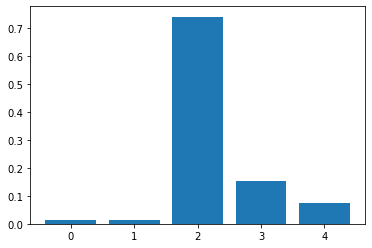

LogisticRegression :
Feature: 0, Score: -0.15027
Feature: 1, Score: -0.21226
Feature: 2, Score: 0.61370
Feature: 3, Score: 0.11111
Feature: 4, Score: 0.11311


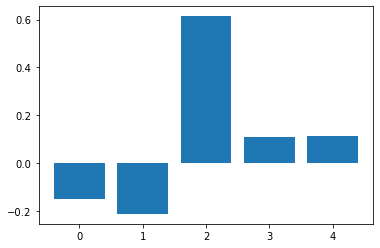

RandomForestClassifier :
Feature: 0, Score: 0.02017
Feature: 1, Score: 0.01789
Feature: 2, Score: 0.51503
Feature: 3, Score: 0.29249
Feature: 4, Score: 0.15442


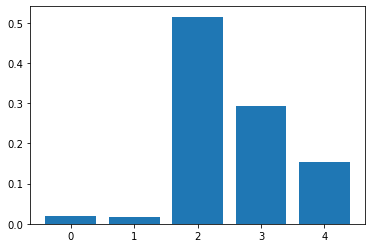

In [187]:
#We can test out different models to see if there is any variation in feature importance based on the features selected using LR:

models = [('DecisionTreeClassifier',DecisionTreeClassifier()),('LogisticRegression',LogisticRegression()),('RandomForestClassifier',RandomForestClassifier())]

for name, model in models:
    #model = DecisionTreeClassifier()
    #scores = evaluate_model(pipe, X_train, y_train)
    #print('%.3f (%.3f)' % (mean(scores), std(scores)))
    
    # evaluate the model
    X_train_selected = X_train[:,[1,3,5,6,7]]
    model.fit(X_train_selected,y_train)
    # get importance
    if name != 'LogisticRegression':
        importance = model.feature_importances_
    else:
        importance = model.coef_[0]
    # summarize feature importance
    print(name,":")
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    plt.show()

We see similar results across different models. It seems that the features 5,6,7 rank highest in order of importance with feature 5 being the most important. So it seems the repayment status features should be used in the final model.

In [19]:
cols[[1,3,5,6,7]]

Index(['sex', 'marriage', 'pay_0', 'pay_2', 'pay_3'], dtype='object')

We can see try running a sample model to see the accuracy based on the previous data preprocessing and selected features how the accuracy is returned on the t
We can consider wrapping this logic of feature selection and importance into a method:

In [20]:
# feature selection
def select_features(X_train, y_train, X_test):

    # configure the SelectFromModel to define both the model we wish to calculate importance scores and the number of features to select, 5 in this case.
    fs = SelectFromModel(LogisticRegression(class_weight='balanced',C=0.01), max_features=5)
    #fs = SelectFromModel(RandomForestClassifier(n_estimators=1000), max_features=5)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# fit the model
model = LogisticRegression(solver='liblinear')
#model = DecisionTreeClassifier()
model.fit(X_train_fs, y_train)
# evaluate the model
yhat = model.predict(X_test_fs)
# evaluate predictions
accuracy = accuracy_score(y_test, yhat)
print('Accuracy: %.2f' % (accuracy*100))

Accuracy: 80.49
/Users/jefching/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Feature Scaling

We notice in the previous example for predicting accuracy running a sample model on the selected features yielded a warning to scale data or increase max iterations. We can consider scaling the features next.

In [2]:
#Load dataset after cleaned data save 
dat = pd.read_csv("~/Documents/Github/Springboard/capstone/1/default_of_credit_card_clients_CLEANED.csv")
##cols = dat.columns
#dat = dat.values
#X, y = dat[:,:-1], dat[:,-1]

In [3]:
dat.iloc[:,[1,3,5,6,7]].head()

,sex,marriage,pay_0,pay_2,pay_3
0,2,1,2,2,-1
1,2,2,-1,2,0
2,2,2,0,0,0
3,2,1,0,0,0
4,1,1,-1,0,-1


We see that all the selected features are using similar scales with not strong variance ['sex', 'marriage', 'pay_0', 'pay_2', 'pay_3']
Before applying scaling techniques, we can consider the distribution of each of the selected features.

array([[<AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'marriage'}>],
       [<AxesSubplot:title={'center':'pay_0'}>,
        <AxesSubplot:title={'center':'pay_2'}>],
       [<AxesSubplot:title={'center':'pay_3'}>, <AxesSubplot:>]],
      dtype=object)

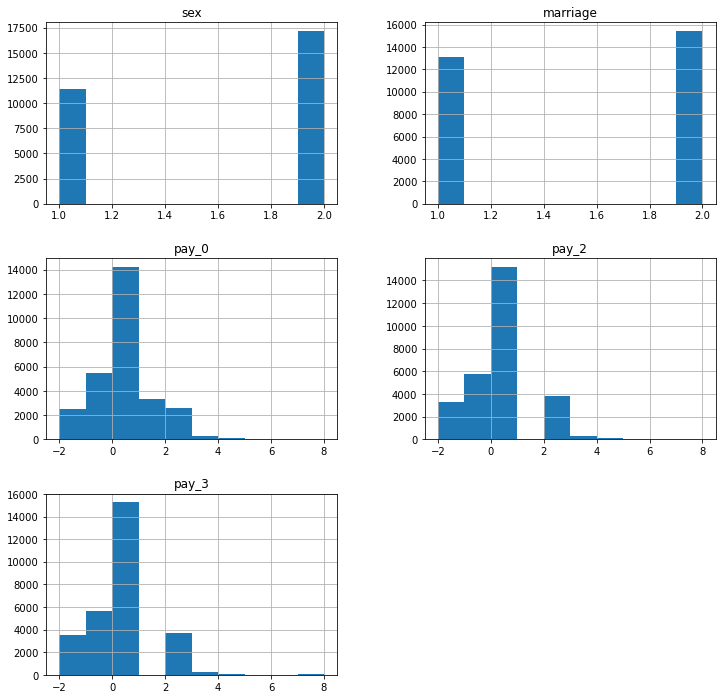

In [4]:
selected_features = dat.iloc[:,[1,3,5,6,7]]
selected_features.hist(bins=10,figsize=(12,12))

We see the features all follow a similar Gaussian distribution with some visible left tail skew. Therefore we can we can consider applying a normalization scaler to all features using MinMaxScaler and a KNN model to test a sample classification accuracy performance of the dataset.

In [5]:
X_selected = selected_features.values
y = dat.values[:,-1]
# ensure inputs are floats and output is an integer label
X_selected = X_selected.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))

# define the pipeline
trans = MinMaxScaler()
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[('t', trans), ('m', model)])
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_selected, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.795 (0.018)


We see we achieve an accuracy score of 79.5% which is not bad. We can compare the performance by using a StandardScaler which scales the data to a mean of 0 and standard deviation of 1.

In [6]:
X_selected = selected_features.values
y = dat.values[:,-1]
# ensure inputs are floats and output is an integer label
X_selected = X_selected.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))

# define the pipeline
trans = StandardScaler()
model = KNeighborsClassifier()
pipeline = Pipeline(steps=[('t', trans), ('m', model)])
# evaluate the pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X_selected, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report pipeline performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.792 (0.027)


We observe accuracy performance is about same between MinMaxScaler() which is normalization versus StandardScaler() which is standardization. In this case, we move forward with MinMaxScaler.

#### Dimensionality Reduction

In [8]:
#Apply PCA for dimensionality reduction

X_selected = selected_features.values
y = dat.values[:,-1]
# ensure inputs are floats and output is an integer label
X_selected = X_selected.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))

# define the pipeline

#try using logistic regresion
steps = [('norm', MinMaxScaler()), ('pca', PCA()), ('m', LogisticRegression())]
#steps = [('pca', PCA(n_components=10)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_selected, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

#try using K nearest neighbors
steps = [('norm', MinMaxScaler()), ('pca', PCA()), ('m', KNeighborsClassifier())]
#steps = [('pca', PCA(n_components=10)), ('m', LogisticRegression())]
model = Pipeline(steps=steps)
# evaluate model
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(model, X_selected, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.809 (0.004)
Accuracy: 0.800 (0.032)


We can see that the PCA transform with logistic regression achieved a performance of about 80.9% and with K nearest neighbors is about 80%.

>1 0.805 (0.004)
>2 0.808 (0.004)
>3 0.808 (0.004)
>4 0.808 (0.004)


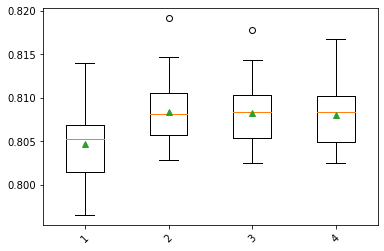

In [12]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1,5):
        steps = [('pca', PCA(n_components=i)), ('m', LogisticRegression())]
        models[str(i)] = Pipeline(steps=steps)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# define dataset
X_selected = selected_features.values
y = dat.values[:,-1]
# ensure inputs are floats and output is an integer label
X_selected = X_selected.astype('float32')
y = LabelEncoder().fit_transform(y.astype('str'))

# get the models to evaluate
models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X_selected, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.xticks(rotation=45)
plt.show()

It seems that PCA selection of 2 components yields the best result.

In summary, we were able to run through each of the important steps for data preprocessing, and narrowing down a processed dataset retaining 5 features (sex, marriage, pay_0, pay_2, pay_3) and 2 components from PCA for dimensionality reduction. We can consider logistic regression for the final model becuase the performance on the train data is fairly high (80.8%) The same data transformations would need to be applied to a test data. Additionally we may need to consider other techniques as we are looking for accuracy on the minority class in this case.